In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import urllib
from shapely.geometry import Point, Polygon
from geopandas.tools import sjoin

% matplotlib inline

In [2]:
# Read in .csv file from NYC Open Data portal

df = pd.read_csv('https://data.cityofnewyork.us/api/views/4e2n-s75z/rows.csv?accessType=DOWNLOAD')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## NYC Open Data Portal dataset cleaning

In [3]:
df.head()

,Date Created,Borough,Map Atlas,Block,Lot,Address,Parcel Name,Agency,Current Uses,Total Area,...,SP Dist 1,SP Dist 2,Potential Urban Ag,Contact,EDC % Occupied,Pluto Version,Latitude,Longitude,BIN,NTA
0,12/11/2013,1,4.0,2,1,MARGINAL STREET,BATTERY MARITIME BLDG / FERRY,"DOT, DSBS","FERRY TERMINAL, WATERFRONT PROPERTY, NO USE",209215,...,LM,NaN,NaN,Christian Grove cgrove@dcas.nyc.gov 212 386-0613,0.0,13v1,NaN,NaN,NaN,NaN
1,12/11/2013,1,4.0,2,23,PIER 6,PIER 6,DSBS,"NO USE, FINAL COMMITMNT-DISP, IN USE-TENANTED,...",510025,...,LM,NaN,NaN,Christian Grove cgrove@dcas.nyc.gov 212 386-0613,0.0,13v1,40.701481,-74.009171,1075697.0,Battery Park City-Lower Manhattan ...
2,12/11/2013,1,4.0,3,1,BATTERY PARK,BATTERY PARK,PARKS,PARK,945425,...,NaN,NaN,NaN,Christian Grove cgrove@dcas.nyc.gov 212 386-0613,0.0,13v1,40.702880,-74.015523,1000000.0,park-cemetery-etc-Manhattan ...
3,12/11/2013,1,4.0,3,2,PETER MINUIT PLAZA,PETER MINUIT PLAZA/BATTERY PK,PARKS,PARK,39900,...,NaN,NaN,NaN,Christian Grove cgrove@dcas.nyc.gov 212 386-0613,0.0,13v1,40.702153,-74.013146,1085598.0,Battery Park City-Lower Manhattan ...
4,12/11/2013,1,4.0,3,3,PETER MINUIT PLAZA,PETER MINUIT PLAZA/BATTERY PK,PARKS,PARK,33600,...,NaN,NaN,NaN,Christian Grove cgrove@dcas.nyc.gov 212 386-0613,0.0,13v1,40.702153,-74.013146,1085598.0,Battery Park City-Lower Manhattan ...


In [4]:
# Check the column names

df.columns

Index(['Date Created', 'Borough', 'Map Atlas', 'Block', 'Lot', 'Address',
       'Parcel Name', 'Agency', 'Current Uses', 'Total Area',
       'Open Petroleum Spill', 'Govt Clean-Up Program', 'Structure Completed',
       'Number Structures', 'Total Gross Area Structures',
       'Ratio Building to Floor Area', 'Allowable Building to Floor Area',
       'Land Use Category', 'Community Board', 'Census Tract', 'Census Block',
       'School Dist', 'Council District', 'Postcode', 'Fire Comp',
       'Health Area', 'Health Ctr', 'Police Prct', 'Major Use',
       'Number of Easements', 'Commercial Floor Area',
       'Residential Floor Area', 'Office Floor Area', 'Retail Floor Area',
       'Garage Floor Area', 'Storage Floor Area', 'Factory Floor Area',
       'Other Floor Area', 'Num Floors', 'Residential Units',
       'Residential and Non-Residential Units', 'Lot Front', 'Lot Depth',
       'Bldg Front', 'Bldg Depth', 'Proximity Code', 'Irr Lot Code',
       'Lot Type Code', 'Bsmt Code

In [5]:
# Look up current usage of each property

df['Current Uses'].value_counts()

NO USE-VACANT LAND                                                                                      8070
NATURAL AREA/ETC                                                                                        7636
PARK                                                                                                    7484
ELEMENTARY SCHOOL                                                                                       2351
COMMUNITY GARDEN                                                                                        2128
ROAD/HIGHWAY                                                                                            1776
NO USE-VACANT LAND;FINAL COMMITMNT-DISP                                                                 1754
NO USE-VACANT LAND, FINAL COMMITMNT-DISP                                                                1024
PLAYGROUND                                                                                               912
FIREHOUSE          

In [6]:
# First, filter for columns needed. Kept all columns that could be used

df_urbag = df[['Date Created','Borough','Block','Lot','Address','Current Uses','Total Area',
               'Number Structures','Total Gross Area Structures','Ratio Building to Floor Area',
               'Allowable Building to Floor Area','Census Tract','Postcode','Num Floors',
               'Industrial Business Zone','Potential Urban Ag','Latitude','Longitude']]

In [7]:
df_urbag.head()

,Date Created,Borough,Block,Lot,Address,Current Uses,Total Area,Number Structures,Total Gross Area Structures,Ratio Building to Floor Area,Allowable Building to Floor Area,Census Tract,Postcode,Num Floors,Industrial Business Zone,Potential Urban Ag,Latitude,Longitude
0,12/11/2013,1,2,1,MARGINAL STREET,"FERRY TERMINAL, WATERFRONT PROPERTY, NO USE",209215,2,280000,1.34,0.0,9.0,10004.0,5.0,NaN,NaN,NaN,NaN
1,12/11/2013,1,2,23,PIER 6,"NO USE, FINAL COMMITMNT-DISP, IN USE-TENANTED,...",510025,1,24346,0.05,10.0,9.0,10004.0,2.0,NaN,NaN,40.701481,-74.009171
2,12/11/2013,1,3,1,BATTERY PARK,PARK,945425,5,945425,1.00,0.0,13.0,10004.0,1.0,NaN,NaN,40.702880,-74.015523
3,12/11/2013,1,3,2,PETER MINUIT PLAZA,PARK,39900,0,0,0.00,0.0,NaN,10004.0,0.0,NaN,NaN,40.702153,-74.013146
4,12/11/2013,1,3,3,PETER MINUIT PLAZA,PARK,33600,1,0,0.00,0.0,9.0,10004.0,0.0,NaN,NaN,40.702153,-74.013146


In [8]:
df.size            

4140300

In [9]:
df.shape

(55950, 74)

In [10]:
df_urbag.size

1007100

In [11]:
df_urbag.shape

(55950, 18)

In [12]:
# Dropping all rows without Latitude and Longitude values

df_urbag.dropna(subset=['Latitude','Longitude'],inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [13]:
df_urbag.size

423576

In [14]:
df_urbag.shape

(23532, 18)

In [15]:
df_urbag['Potential Urban Ag'].value_counts()

Not Suitable 1 - Site is not suitable for any one or more of these reasons: land-based reasons; reserved for agency purposes; no safe access to the site; site is part of a built street/highway.    1365
Existing GreenThumb Garden                                                                                                                                                                            921
Not Suitable 2 - Site is smaller than 2500 square feet                                                                                                                                                350
Pending                                                                                                                                                                                               248
Potentially Suitable 3 - Site has specific instructions or conditions that limit its availability and/or use                                                                                    

In [16]:
df_urbfarm = df_urbag.dropna(subset=['Potential Urban Ag'])

In [17]:
df_urbfarm.head()

,Date Created,Borough,Block,Lot,Address,Current Uses,Total Area,Number Structures,Total Gross Area Structures,Ratio Building to Floor Area,Allowable Building to Floor Area,Census Tract,Postcode,Num Floors,Industrial Business Zone,Potential Urban Ag,Latitude,Longitude
11,12/11/2013,1,19,8,65 GREENWICH STREET,OTHER TRANS FACILITY,71,1,0,0.0,10.00,13.00,10006.0,1.0,NaN,Not Suitable 2 - Site is smaller than 2500 squ...,40.707047,-74.013984
55,12/11/2013,1,95,43,46 CLIFF STREET,TRANSIT SUBSTATION,0,1,0,0.0,10.00,15.01,10038.0,0.0,NaN,Not Suitable 2 - Site is smaller than 2500 squ...,40.708527,-74.004447
81,12/11/2013,1,132,7,77 MURRAY STREET,TRANSIT SUBSTATION,4975,1,0,0.0,6.02,21.00,10007.0,0.0,NaN,Not Suitable 1 - Site is not suitable for any ...,40.714727,-74.010894
101,12/11/2013,1,159,51,122 PARK ROW,TRANSIT SUBSTATION,0,1,0,0.0,3.44,29.00,10007.0,0.0,NaN,Not Suitable 2 - Site is smaller than 2500 squ...,40.712787,-74.001923
158,12/11/2013,1,275,2,127 MADISON STREET,ROAD/HIGHWAY,116,0,0,0.0,3.44,8.00,10002.0,0.0,NaN,Not Suitable 2 - Site is smaller than 2500 squ...,40.712362,-73.993839


In [18]:
# Filter for values that have been designated suitable for urban agriculture purposes
# This is based on the category system 

df_urbfarm2 = df_urbfarm[df_urbfarm['Potential Urban Ag'].str.contains('Potentially Suitable 1', regex=False)]

In [19]:
df_urbfarm2.size

1260

In [20]:
df_urbfarm2.shape

(70, 18)

In [21]:
df_urbfarm2.head()

,Date Created,Borough,Block,Lot,Address,Current Uses,Total Area,Number Structures,Total Gross Area Structures,Ratio Building to Floor Area,Allowable Building to Floor Area,Census Tract,Postcode,Num Floors,Industrial Business Zone,Potential Urban Ag,Latitude,Longitude
1490,12/11/2013,1,2106,1,506 EDGECOMBE AVENUE,"PARK, MATERIAL PROCESS FAC",3293950,6,20054,0.01,0.00,311.0,10032.0,1.0,NaN,Potentially Suitable 1 - Site is available for...,40.832132,-73.940039
1880,12/11/2013,2,2403,37,387 EAST 156 STREET,"NO USE-VACANT LAND, FINAL COMMITMNT-DISP",2646,0,0,0.00,2.43,69.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.820963,-73.916138
2115,12/11/2013,2,2616,22,626 ST ANNS AVENUE,PARK,1794,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.815816,-73.912063
2116,12/11/2013,2,2616,26,578 WESTCHESTER AVENUE,PARK,3309,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.816005,-73.911499
2117,12/11/2013,2,2616,28,582 WESTCHESTER AVENUE,PARK,2554,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.815999,-73.911412


## Download Shape File

In [22]:
#urllib.request.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/bk_mappluto_18v1.zip',
#                        'pluto.zip')

In [23]:
#! unzip -a pluto.zip

In [24]:
bkmap = gpd.read_file('BKMapPLUTO.shp')

In [25]:
bkmap.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,BK,5983,66,310,140,1000,20,43,11228,E284,...,0.0,None,1,None,None,18V1,0,2274.090422,246.640861,"POLYGON ((979349.3505859375 166002.4368286133,..."
1,BK,6714,55,314,534,3000,21,44,11230,L156,...,0.0,None,1,None,None,18V1,0,3421.921447,270.323044,"POLYGON ((994429.516418457 166222.5836181641, ..."
2,BK,5928,69,310,66,3002,20,43,11209,E241,...,0.0,None,1,None,None,18V1,0,1908.736476,235.629951,"POLYGON ((976060.1929931641 169625.9860229492,..."
3,BK,4597,46,317,884,1001,17,41,11212,E283,...,0.0,None,1,None,None,18V1,0,1777.730194,222.690410,"POLYGON ((1004845.411010742 180910.8154296875,..."
4,BK,7405,802,315,594.02,3000,22,48,11229,E321,...,0.0,None,1,None,None,18V1,0,1436.210701,227.099367,"POLYGON ((1000189.150634766 156188.2463989258,..."


In [26]:
bkmap.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

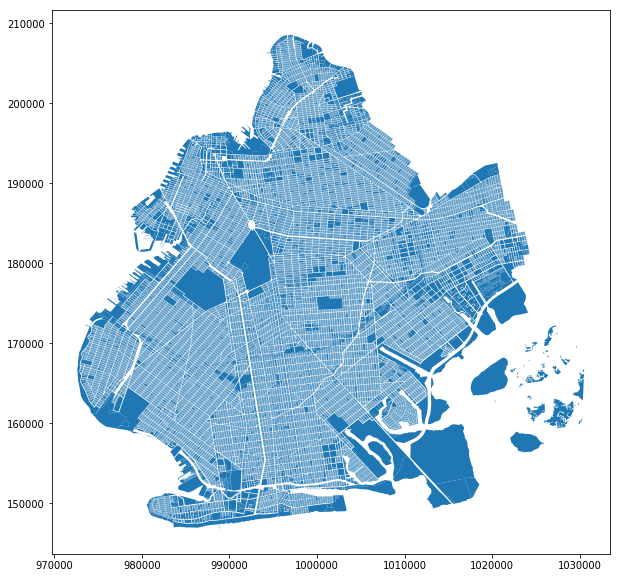

In [27]:
#Plot Brooklyn shape file

fig, ax = plt.subplots(figsize=(10,10))

bkmap.plot(ax = ax)

## Merge Dataframes

In [28]:
geometry = [Point(xy) for xy in zip(df_urbfarm2['Latitude'], df_urbfarm2['Longitude'])]

geometry[:3]

In [29]:
len(geometry)

70

In [30]:
crs = {'init' : 'epsg:4326'}

In [31]:
geo_urbfarm2 = gpd.GeoDataFrame(df_urbfarm2,
                               crs = crs,
                               geometry = geometry)

In [32]:
geo_urbfarm2.head()

,Date Created,Borough,Block,Lot,Address,Current Uses,Total Area,Number Structures,Total Gross Area Structures,Ratio Building to Floor Area,Allowable Building to Floor Area,Census Tract,Postcode,Num Floors,Industrial Business Zone,Potential Urban Ag,Latitude,Longitude,geometry
1490,12/11/2013,1,2106,1,506 EDGECOMBE AVENUE,"PARK, MATERIAL PROCESS FAC",3293950,6,20054,0.01,0.00,311.0,10032.0,1.0,NaN,Potentially Suitable 1 - Site is available for...,40.832132,-73.940039,POINT (40.832132 -73.940039)
1880,12/11/2013,2,2403,37,387 EAST 156 STREET,"NO USE-VACANT LAND, FINAL COMMITMNT-DISP",2646,0,0,0.00,2.43,69.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.820963,-73.916138,POINT (40.820963 -73.916138)
2115,12/11/2013,2,2616,22,626 ST ANNS AVENUE,PARK,1794,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.815816,-73.912063,POINT (40.815816 -73.912063)
2116,12/11/2013,2,2616,26,578 WESTCHESTER AVENUE,PARK,3309,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.816005,-73.911499,POINT (40.816005 -73.91149899999999)
2117,12/11/2013,2,2616,28,582 WESTCHESTER AVENUE,PARK,2554,0,0,0.00,0.00,73.0,10455.0,0.0,NaN,Potentially Suitable 1 - Site is available for...,40.815999,-73.911412,POINT (40.815999 -73.911412)


In [33]:
geo_urbfarm2.to_csv('urbanfarmdata.csv')